In [24]:
# coding: utf-8

# ##### Los features que vamos a utilizar son:
# 
# Potencia para cada banda de frecuencia (Delta, Theta, Alpha, Beta y Gamma)

# Potencia normalizada para las mismas bandas de frecuencia.

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import glob 
import sys
import getopt
from scipy import stats
from scipy.signal import welch
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from collections import OrderedDict

def analisis_espectral(serie):
    """ Transformada de Welch para la serie de tiempo serie"""

    return welch(serie, fs=250, nfft=2048, nperseg=201)

def fix_max(x, m):
    """ Funcion para poner el maximo de la serie en el
    bin que le corresponde """
    if int(x) == m:
        return m - 1
    else:
        return x
    
def symb(serie):
    """ Dada una serie continua devuelve una 
    representación en símbolos y el simbolo mayor. 
    Cada simbolo es un entero mayor o igual a cero.
    Usa la regla de Scott """
    
    # Computo el N
    std = np.std(serie)
    maximo = np.amax(serie)
    minimo = np.amin(serie)
    t = np.power(len(serie), -1/3)
    #print([std, maximo, minimo, t])
    N = np.ceil((maximo - minimo) / (3.5*std*t))
    
    # Transformo la serie en simbolos
    step = np.abs(maximo - minimo)/N
    simb = np.floor(np.divide(np.subtract(serie, np.amin(serie)), step))
    
    return int(N), np.array([fix_max(s, int(N)) for s in simb])


def prob(serie):
    """ Dada una serie de numeros, devuelve la distribucion
    de los simbolos que la representan.
    """
    
    bins, simbolos = symb(serie)
    if bins == 0:
        print("BINS DIO CERO!")
    if bins - 1 != np.amax(simbolos):
        print("PROBLEMAS!!")
            
            
    hist = [0] * bins
    for s in simbolos:
        hist[int(s)] = hist[int(s)] + 1
                
    return np.divide(hist, np.sum(hist))
        

def entropia(serie):
    """ Calcula la entropia de la señal serie, medida en bits """
    
    p = prob(serie)
    p = p[p>0]
    return -np.inner(p, np.log2(p))


def entropia_conjunta(serie1, serie2):
    """ Calcula la entropía conjunta de las dos
    series parámetro """
    
    bins1, s1 = symb(serie1)
    bins2, s2 = symb(serie2)
    
    hist = {}
    for ss1 in s1:
        for ss2 in s2:
            if str(ss1)+'-'+str(ss2) in hist:
                hist[str(ss1)+'-'+str(ss2)] = hist[str(ss1)+'-'+str(ss2)] + 1
            else:
                hist[str(ss1)+'-'+str(ss2)] = 1
                
    values = list(hist.values())
    probs = np.divide(values, np.sum(values))
    return -np.inner(probs, np.log2(probs))


#TP2
def Mat2Data(filename):
    """ Lee los datos desde filename (.mat) a un np array """
    
    mat = loadmat(filename)  # load mat-file    
    mdata = mat['data']  # variable in mat file
    return mdata

##TP Definiciones
bandasRango = OrderedDict([("delta", (0,4.0)), ("theta", (4.0,8.0)), ("alpha", (8.0,13.0)), ("beta", (13.0,30.0)), ("gamma", (30.0,126.0))])
bandas = bandasRango.keys() 

##TP Definiciones
labels=['P','S']
pacientes=[]
for l in labels:
    pacientes += [l + "{:02d}".format(i) for i in range(1,  11)]


columnas = np.concatenate((
    ['name'],
    list(map(lambda n: n+'_m', bandas)), 
    list(map(lambda n: n+'_norm_m', bandas)), 
    list(map(lambda n: n+'_std', bandas)),
    list(map(lambda n: n+'_norm_std', bandas)),
    ['intra_media'],
    ['intra_desvio'],
    ['inter_media'],
    ['inter_desvio'],
    ['label']
))
#columnas

##Definiciones Auxiliares
def bandaID(freq):
    for k, (_, v) in enumerate(bandasRango.items()):
        if freq >= v[0] and freq < v[1]:
            return k



In [25]:
def load(name):
    """ Lee los datos desde filename (.mat) a un np array """    
    sujeto_file = './DataSet/'+name+'.mat' #file path de un sujeto    
    #sujeto_file = '/media/laura/DISK_IMG/TP2/'+name+'.mat' #file path de un sujeto    
    #sujeto_file = '/home/nico/Descargas/datos EEG/'+name+'.mat'
    return Mat2Data(sujeto_file)

In [26]:
electrodos = [7, 43, 79, 130, 184]

# TODO consultar: TP2 b) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) 
# y epochs para cada sujeto.
# Entiendo que debe ser las medias del analisis espectral en vez de el análisis espectral de las medias (b1)
# El cálculo del poder espectral en cada banda se realiza sumando los valores obtenidos de la FFT que corresponden a las
# frecuencias incluídas en la misma.
def poderEspectral(sujeto):
    poderEpochs = []
    poderNormalizado = []
    for epoch in range(0, len(sujeto)):#len(sujeto)
        poderElectrodos = []
        poderElectrodosNorm = []

        for electrodo in electrodos:
            freq, pot = analisis_espectral(sujeto[epoch][electrodo])                
            poderFreq = np.zeros(len(bandas))
            for f, p in zip(freq, pot):            
                poderFreq[bandaID(f)] += p
            
            poderElectrodos.append(poderFreq)
            suma= sum(poderFreq)
            poderElectrodosNorm.append(poderFreq/suma)
        
        poder=list(np.mean(poderElectrodos,axis=0))
        poderEpochs.append(poder)
        poderNorm = list(np.mean(poderElectrodosNorm, axis=0))
        poderNormalizado.append(poderNorm)
    return poderEpochs, poderNormalizado    

# Calcula las medidas de informacion de un paciente para
# utilizar en una como feature.
def informacionPorEpoch(sujeto):
    intraPorEpoch = []
    interPorEpoch = []

    for epoch in range(0, len(sujeto)):
        intraPorEpoch.append(entropia(sujeto[epoch][electrodos[0]]))

        serie1 = sujeto[epoch][electrodos[0]]
        serie2 = sujeto[epoch][electrodos[1]]
        interPorEpoch.append(entropia_conjunta(serie1, serie2))

    return intraPorEpoch, interPorEpoch


def mainFeatures(outFile):
    data = pd.DataFrame({})
    for paciente in pacientes:
        print("Extrayendo features del paciente " + paciente)
        sujeto = load(paciente)
        poderEspectralEpochs, poderNormalizadoEpochs = poderEspectral(sujeto)
        
        # Espectrales
        media_espectral = np.mean(poderEspectralEpochs, axis=0)
        media_normalizados = np.mean(poderNormalizadoEpochs, axis=0)
        desvio_espectral = np.std(poderEspectralEpochs, axis=0)
        desvio_normalizado = np.std(poderNormalizadoEpochs, axis=0)

        # Informacion
        intraPorEpoch, interPorEpoch = informacionPorEpoch(sujeto)
        intra_media = np.mean(intraPorEpoch)
        intra_desvio = np.std(intraPorEpoch)
        inter_media = np.mean(interPorEpoch)
        inter_desvio = np.std(interPorEpoch)
        
        serie = pd.Series(np.concatenate(([paciente],media_espectral, 
                                                    media_normalizados, 
                                                    desvio_espectral, 
                                                    desvio_normalizado, 
                                                    [intra_media, intra_desvio, inter_media, inter_desvio],
                                                    [paciente[0]]), axis=0))
                         
        #save to csv
        df = pd.DataFrame({})
        df=df.append(serie, ignore_index=True)        
        df.to_csv('./features/'+outFile +'.csv', mode='a', header=False, index =False)        
        df.to_csv('./features/'+outFile + paciente + '.csv', mode='w', index =False)
        
        data = pd.concat([data, df], ignore_index=True)
    return data


def generar():
    
    # Par generar el encabezado
    outFile = 'features'
    df = pd.DataFrame(columns=columnas)
    df.to_csv('./features/'+outFile+'.csv', columns=columnas, index =False)

    return mainFeatures(outFile)


In [27]:
# sin encabezados en el df, con encabezados en el cvs
#df=generar()


In [28]:
df = pd.read_csv('./features/features.csv')
df

,name,delta_m,theta_m,alpha_m,beta_m,gamma_m,delta_norm_m,theta_norm_m,alpha_norm_m,beta_norm_m,...,delta_norm_std,theta_norm_std,alpha_norm_std,beta_norm_std,gamma_norm_std,intra_media,intra_desvio,inter_media,inter_desvio,label
0,P01,1.820060e-10,4.193477e-11,1.271420e-11,1.284374e-11,4.064776e-12,0.600975,0.202242,0.084284,0.081176,...,0.156152,0.104318,0.067432,0.057175,0.031643,2.682407,0.133683,5.400745,0.206373,P
1,P02,2.899948e-10,8.088919e-11,1.010285e-11,9.566091e-12,4.446439e-12,0.664863,0.247549,0.035458,0.035676,...,0.151989,0.130336,0.022475,0.022805,0.013441,2.677918,0.118371,5.337999,0.192485,P
2,P03,4.626000e-10,9.369159e-11,1.679977e-11,8.763612e-12,2.080777e-12,0.716866,0.200345,0.048656,0.027387,...,0.120525,0.099431,0.035775,0.018168,0.004911,2.649811,0.114165,5.313550,0.182915,P
3,P04,2.083821e-10,8.503306e-11,2.553738e-11,1.017814e-11,2.099500e-12,0.544600,0.302063,0.100028,0.043795,...,0.168151,0.133856,0.065015,0.027929,0.007413,2.694329,0.106098,5.396279,0.163300,P
4,P05,3.782186e-10,7.668485e-11,2.006228e-11,1.588148e-11,7.873227e-12,0.681836,0.190407,0.056125,0.047713,...,0.121286,0.093529,0.031243,0.027368,0.018770,2.674118,0.128263,5.384873,0.183078,P
5,P06,2.512993e-10,5.079392e-11,3.231625e-11,1.346849e-11,1.609475e-12,0.629021,0.182181,0.123947,0.057832,...,0.155882,0.105617,0.077346,0.043907,0.004377,2.665170,0.136268,5.365079,0.195639,P
6,P07,2.338226e-10,8.444352e-11,9.468261e-12,1.274051e-11,6.175824e-12,0.632154,0.237292,0.044688,0.059762,...,0.132851,0.093004,0.032891,0.047495,0.032841,2.707679,0.097212,5.421100,0.153673,P
7,P08,1.219574e-10,3.490999e-11,5.318461e-12,5.586848e-12,2.830907e-12,0.579650,0.268912,0.054173,0.065596,...,0.159289,0.122845,0.036782,0.037586,0.023551,2.655926,0.165371,5.325498,0.282520,P
8,P09,2.116241e-10,1.108578e-10,1.761568e-11,1.610284e-11,5.139599e-12,0.517835,0.328192,0.065847,0.064863,...,0.134775,0.116165,0.035813,0.037113,0.015999,2.718521,0.094809,5.459370,0.146359,P
9,P10,2.778104e-10,5.564402e-11,1.405172e-11,1.520825e-11,5.307311e-12,0.667719,0.194927,0.057502,0.060090,...,0.137587,0.100992,0.035955,0.035273,0.017353,2.680415,0.119093,5.353328,0.194293,P


In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split


In [30]:
def plotROC(xs, ys, name):
    print(name)
    y_true = label_binarize(ys, classes=['P', 'S']).ravel()
    y_score = xs

    # Compute ROC curve and ROC area for each class     
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
        
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic example')
    plt.title('ROC Curve: ' + name)
    plt.legend(loc="lower right")
    plt.show()

def featuresROC(df, ys):
    
    for k in range(1,25):
        name = columnas[k]
        
        xs = np.concatenate(df.loc[:,[name]].values)
        plotROC(xs, ys, name,)


delta_m


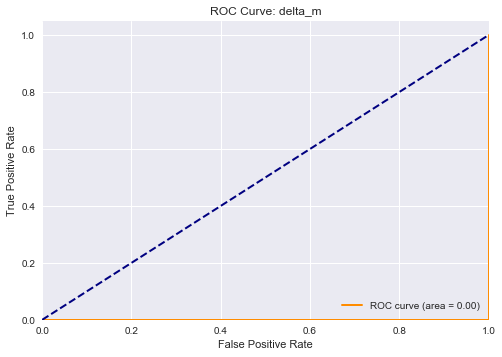

theta_m


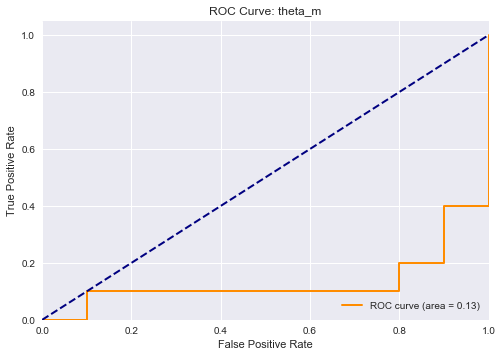

alpha_m


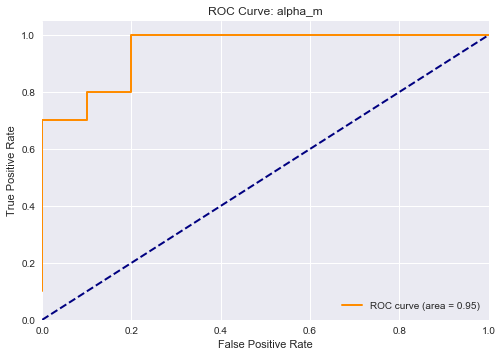

beta_m


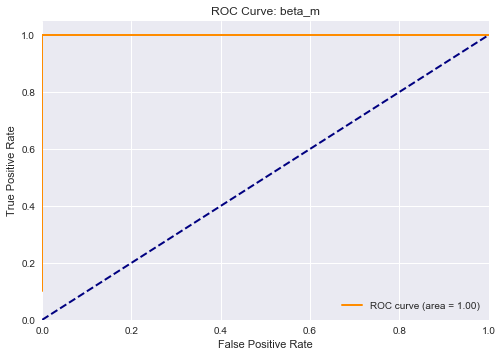

gamma_m


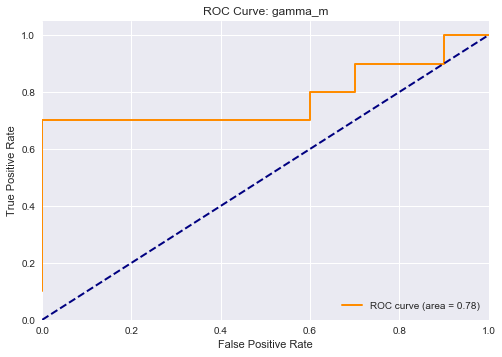

delta_norm_m


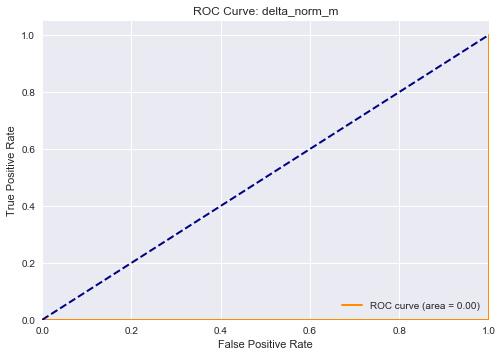

theta_norm_m


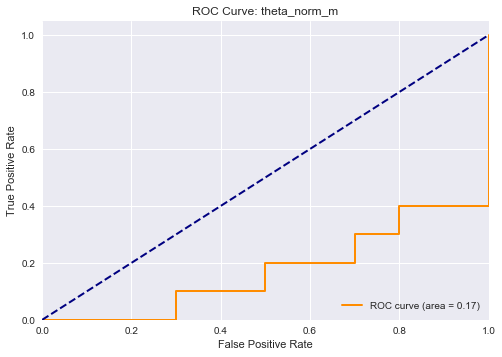

alpha_norm_m


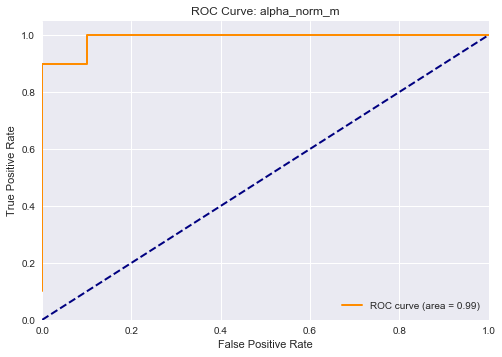

beta_norm_m


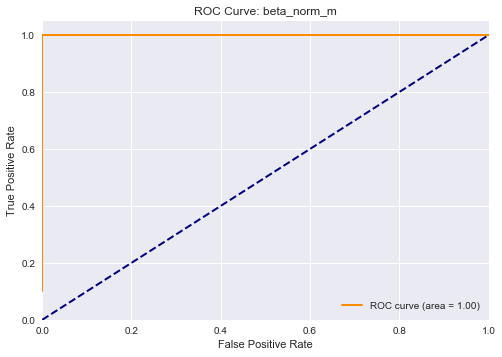

gamma_norm_m


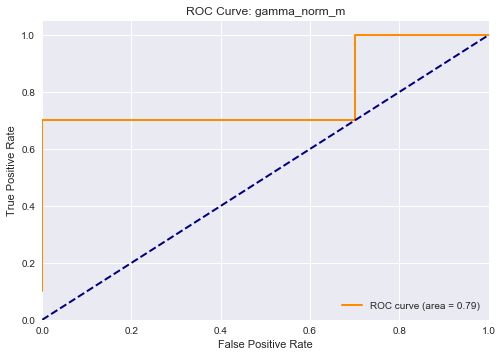

delta_std


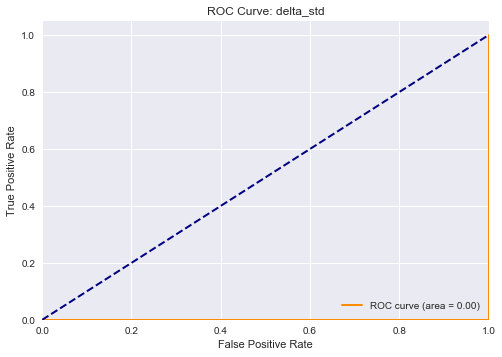

theta_std


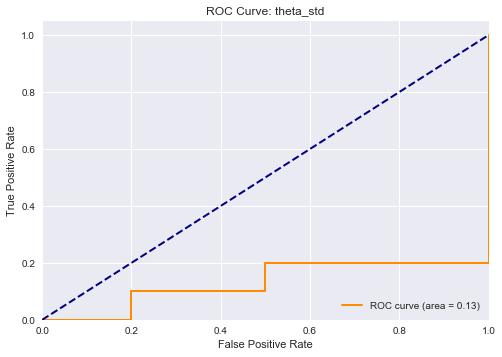

alpha_std


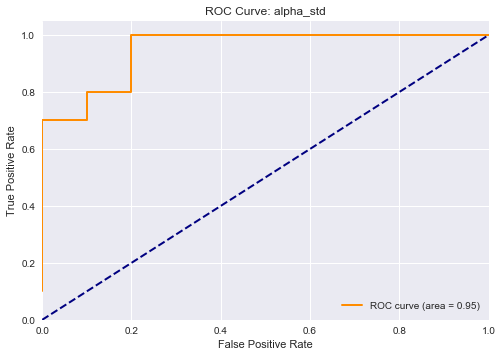

beta_std


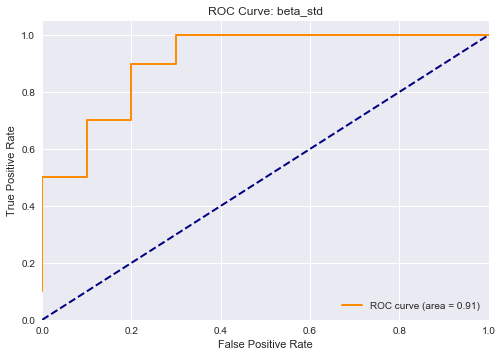

gamma_std


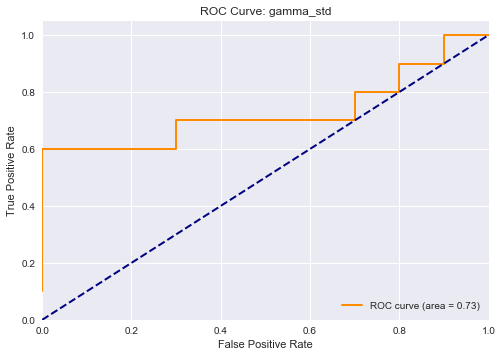

delta_norm_std


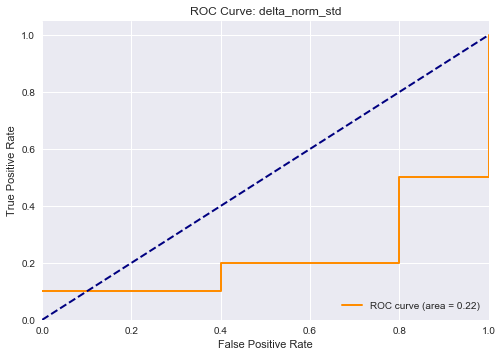

theta_norm_std


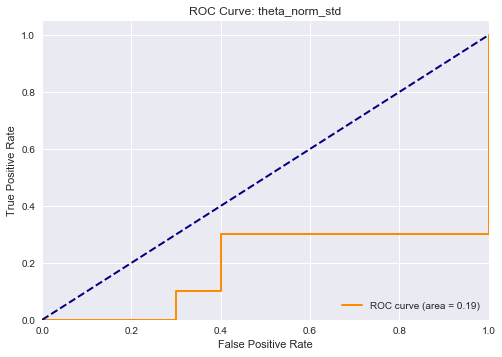

alpha_norm_std


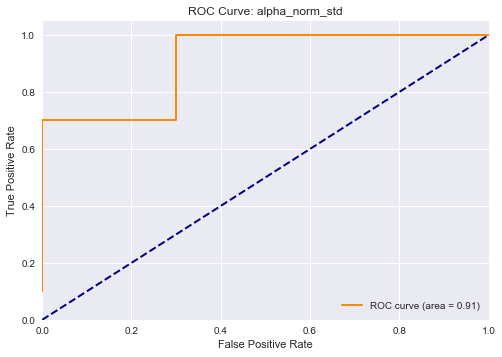

beta_norm_std


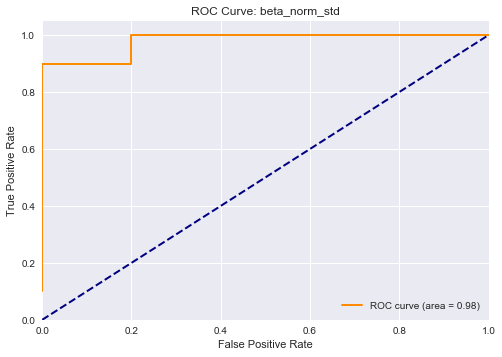

gamma_norm_std


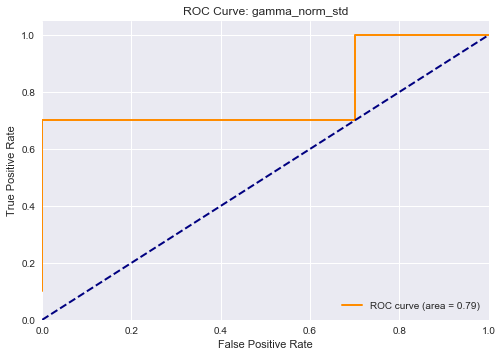

intra_media


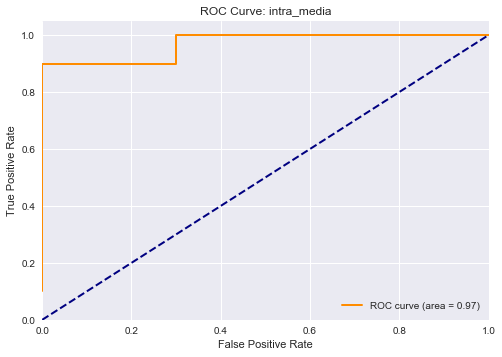

intra_desvio


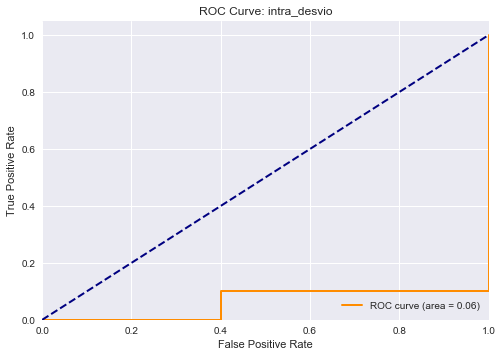

inter_media


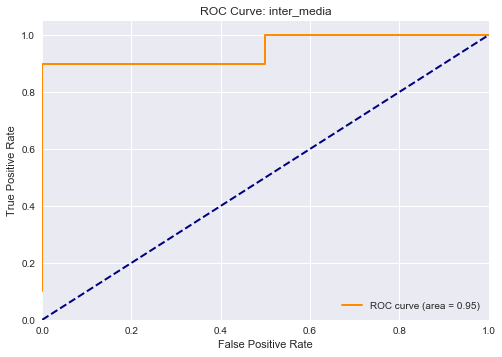

inter_desvio


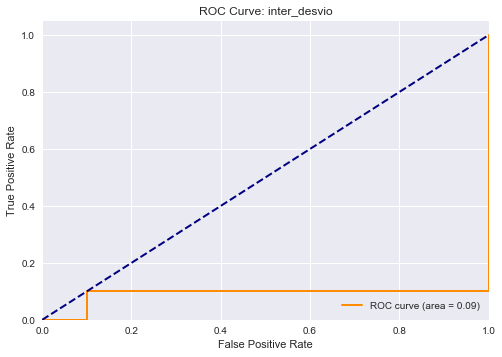

In [31]:
#TODO consultar
#ys =['P']*10+['S']*10

ys =['P']*10+['S']*10
featuresROC(df, ys)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

def featuresCVROC(df, ys):
    
    for k in range(1,25):
        name = columnas[k]
        xs = np.concatenate(df.loc[:,[name]].values)
        plotCVROC(xs, ys, name)


# TODO consultar
def plotCVROC(xs, ys, name):
    print(name)
    y_true = label_binarize(ys, classes=['P', 'S']).ravel()
    
    # split X and y into training and testing sets    
    xs_train, xs_test, y_train, y_test = train_test_split(xs, y_true)
    
    #DeprecationWarning
    xs_train = xs_train.reshape(-1,1)
    xs_test = xs_test.reshape(-1,1)    
        
    # train a logistic regression model on the training set
    #model = LogisticRegression()
    #model = model.fit(xs_train, y_train)
    
    
    #LogisticRegressionCV implements Logistic Regression with builtin cross-validation
    model = LogisticRegressionCV()
    model = model.fit(xs_train, y_train)    
    
    # make class predictions for the testing set
    #y_pred_class = model.predict(xs_test)    
    #y_score = model.predict(xs_test)
    y_predict_probabilities = model.predict_proba(xs_test)[:,0]#[:,1]
        
    # calculate accuracy
    #from sklearn import metrics
    #metrics.accuracy_score(y_test, y_pred_class)
    
    # Compute ROC curve and ROC area for each class     
    fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
    roc_auc = auc(fpr, tpr)
    #print('y_test:', y_test)
    #print('y_prob:', y_predict_probabilities)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic example')
    plt.title('ROC Curve: ' + name)
    plt.legend(loc="lower right")
    plt.show()

# TODO eliminar codigo repetido :(

delta_m


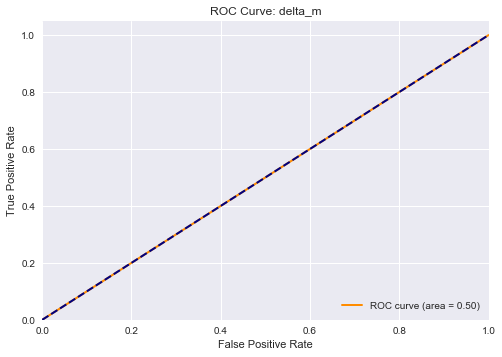

theta_m


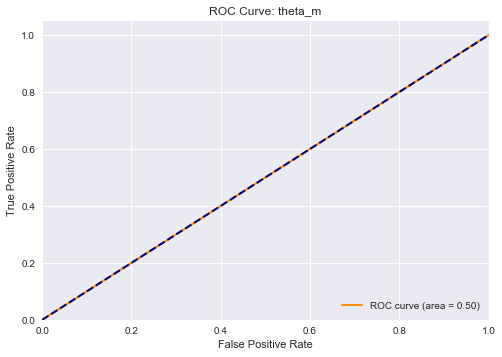

alpha_m


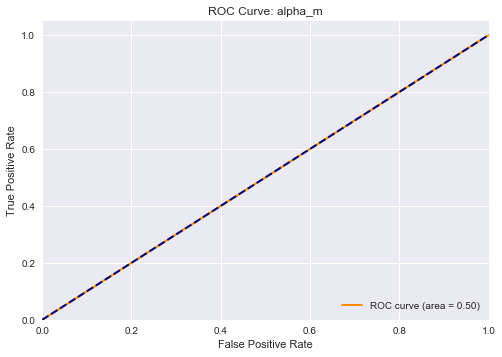

beta_m


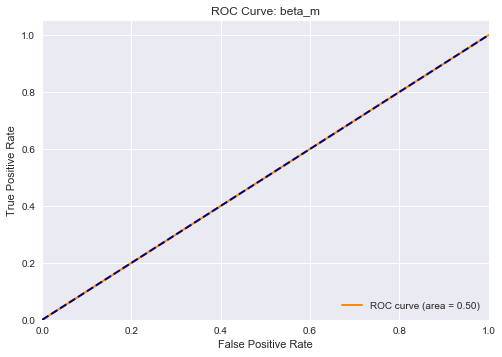

gamma_m


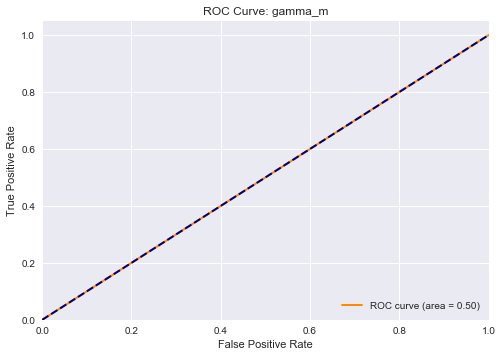

delta_norm_m


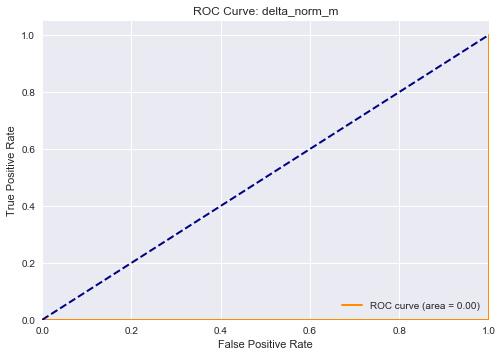

theta_norm_m


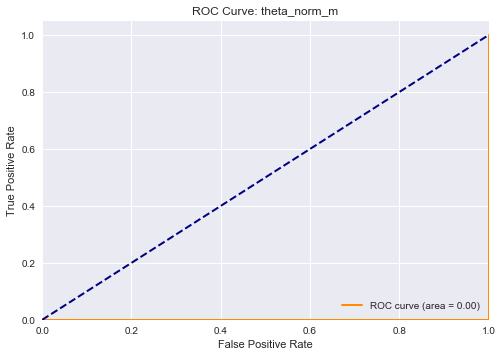

alpha_norm_m


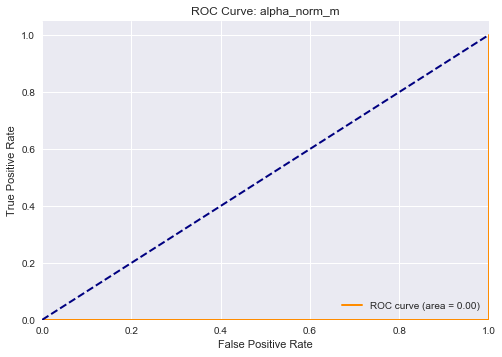

beta_norm_m


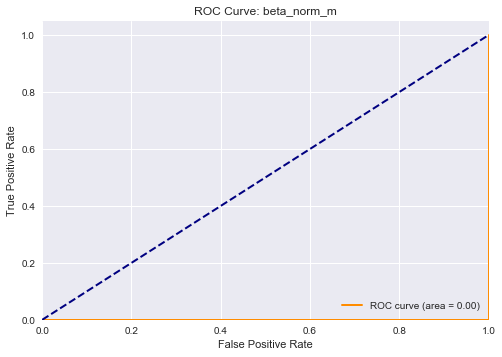

gamma_norm_m


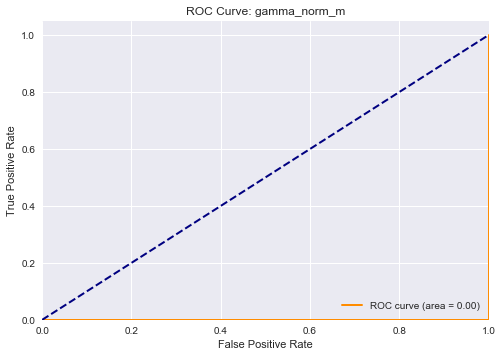

delta_std


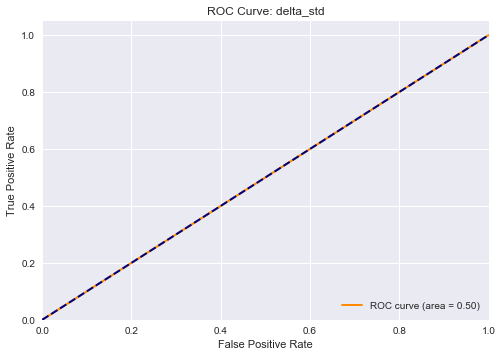

theta_std


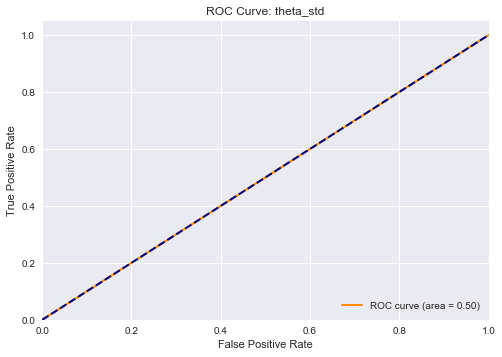

alpha_std


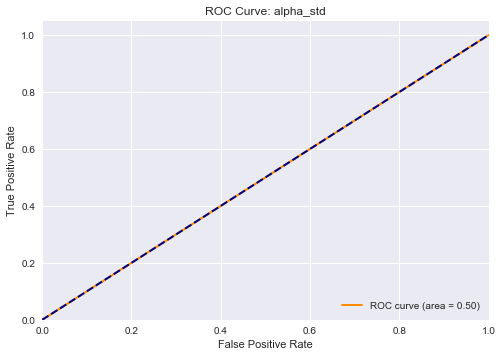

beta_std


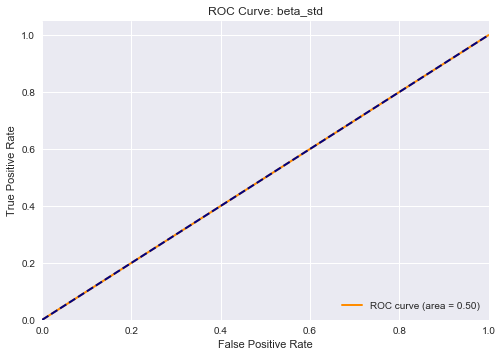

gamma_std


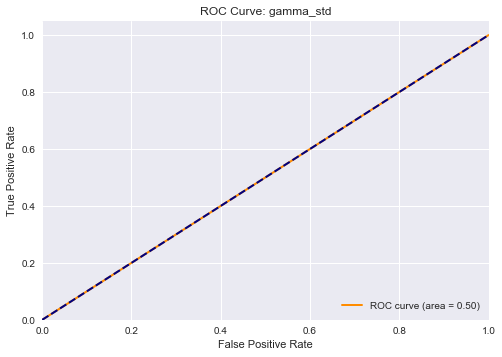

delta_norm_std


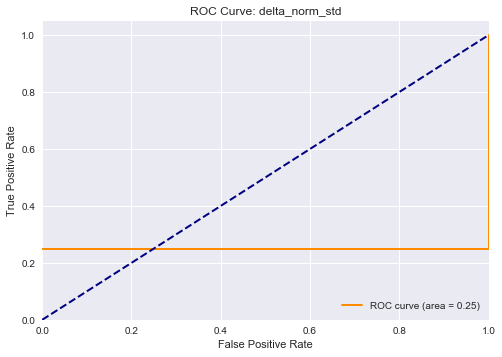

theta_norm_std


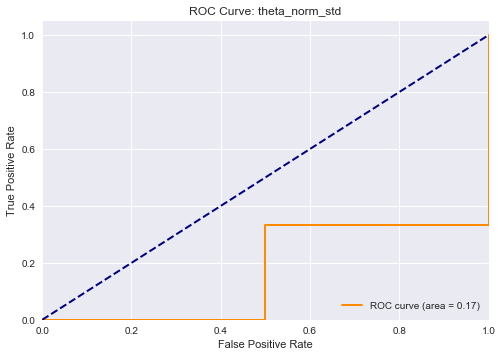

alpha_norm_std


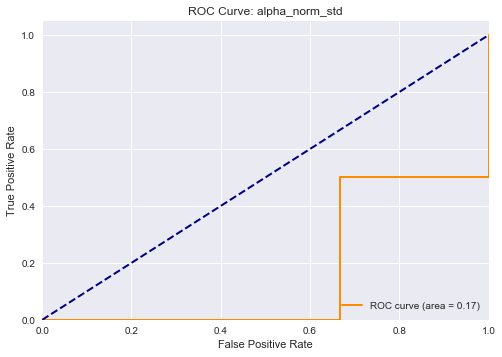

beta_norm_std


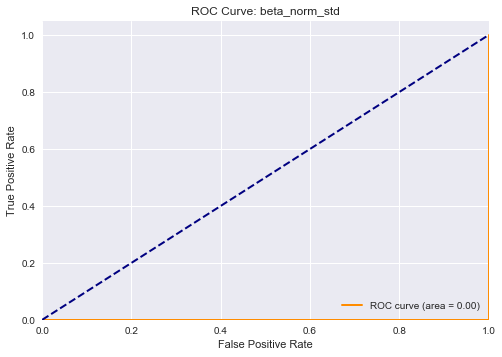

gamma_norm_std


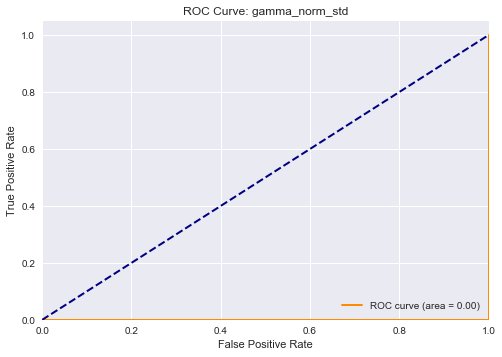

intra_media


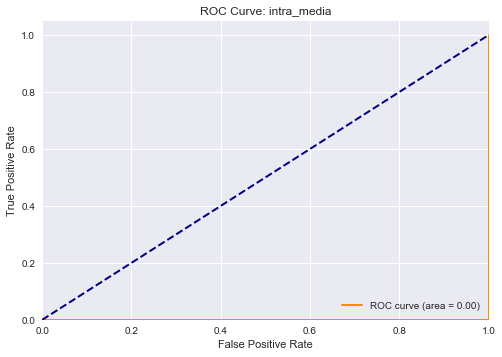

intra_desvio


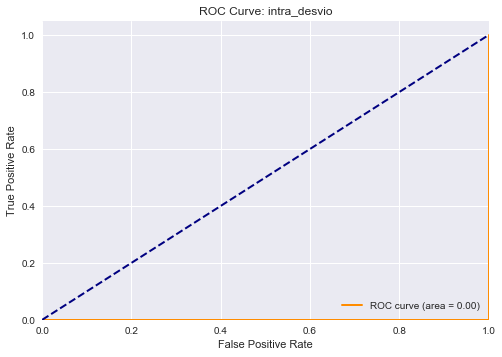

inter_media


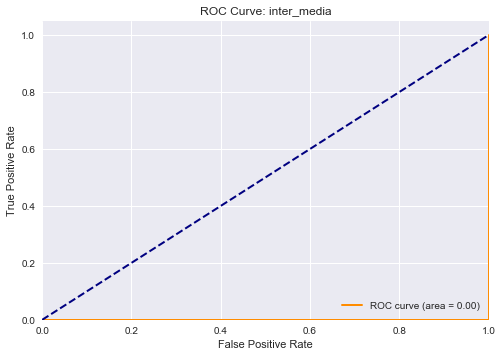

inter_desvio


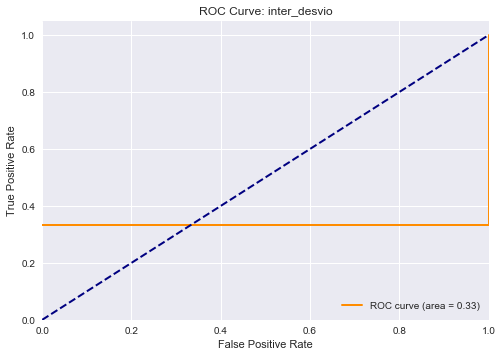

In [33]:
featuresCVROC(df, ys)


In [34]:
from sklearn import svm

def featuresSVMROC(df, ys):
    xs = df.loc[:,columnas[1:25]]
    plotSVMROC(xs, ys)

# TODO consultar
def plotSVMROC(xs, ys):    
    y_true = label_binarize(ys, classes=['P', 'S']).ravel()
    
    # split X and y into training and testing sets    
    xs_train, xs_test, y_train, y_test = train_test_split(xs, y_true)
    
    #DeprecationWarning
    #xs_train = xs_train.reshape(-1,1)
    #xs_test = xs_test.reshape(-1,1)    
        
    # train model on the training set
    model = svm.SVC(probability=True)
    model = model.fit(xs_train, y_train)
    
    # make class predictions for the testing set
    #y_pred_class = model.predict(xs_test)    
    #y_score = model.predict(xs_test)
    y_predict_probabilities = model.predict_proba(xs_test)[:,0]#[:,1]
        
    # Compute ROC curve and ROC area for each class     
    fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
    roc_auc = auc(fpr, tpr)
        
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic example')
    plt.title('ROC Curve SVM')
    plt.legend(loc="lower right")
    plt.show()


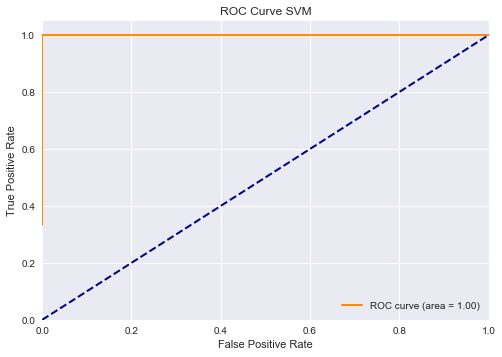

In [35]:
featuresSVMROC(df, ys)

In [36]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile

def featuresPipelineSVMROC(df, ys, n_percentile):
    xs = df.loc[:,columnas[1:25]]    
    plotPipelineSVMROC(xs, ys, n_percentile)

# TODO consultar
def plotPipelineSVMROC(xs, ys, n_percentile):    
    y_true = label_binarize(ys, classes=['P', 'S']).ravel()
    
    # split X and y into training and testing sets    
    xs_train, xs_test, y_train, y_test = train_test_split(xs, y_true)
    
    #1. Standard Scaler
    #2. Feature Selection utilizando solo el 10%.
    #3. SVC            
    model = make_pipeline(StandardScaler(), SelectPercentile(percentile=n_percentile), svm.SVC(probability=True))
    print('percentile:', n_percentile)
    
    # train model on the training set    
    model = model.fit(xs_train, y_train)
    
    # make class predictions for the testing set
    #y_pred_class = model.predict(xs_test)    
    #y_score = model.predict(xs_test)
    y_predict_probabilities = model.predict_proba(xs_test)[:,0]#[:,1]
        
    # Compute ROC curve and ROC area for each class     
    fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
    roc_auc = auc(fpr, tpr)
    print('y_test:', y_test)
    print('y_prob:', y_predict_probabilities)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic example')
    plt.title('ROC Curve Pipeline SVM')
    plt.legend(loc="lower right")
    plt.show()


percentile: 10
y_test: [1 0 0 0 0]
y_prob: [ 0.12718339  0.85257572  0.66742296  0.90506612  0.81899003]


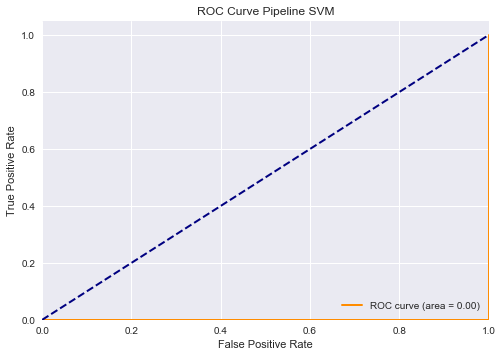

In [37]:
featuresPipelineSVMROC(df, ys, 10)

percentile: 25
y_test: [0 0 1 1 1]
y_prob: [ 0.9475083   0.94323466  0.12649187  0.59104687  0.10809591]


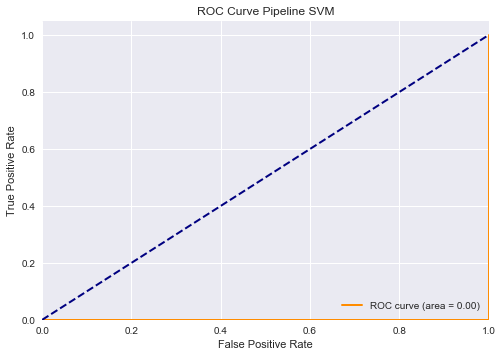

In [38]:
featuresPipelineSVMROC(df, ys, 25)

percentile: 35
y_test: [0 0 1 0 0]
y_prob: [ 0.89496989  0.94271199  0.07659473  0.68944545  0.82960379]


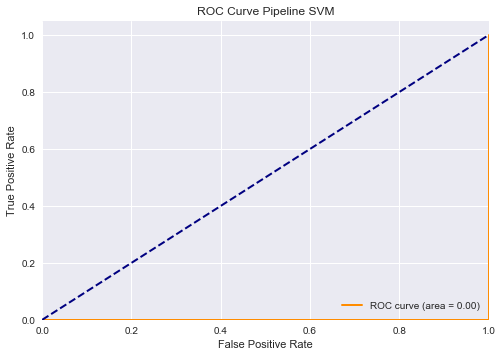

In [39]:
featuresPipelineSVMROC(df, ys, 35)

In [40]:
#Punto 1
#primera parte.
#Para ver agrupadas
def plotAllROC(xs, ys, name):
    y_true = label_binarize(ys, classes=['P', 'S']).ravel()
    y_score = xs

    # Compute ROC curve and ROC area for each class     
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    lw = 2
    plt.plot(fpr, tpr, 
         lw=lw, label='ROC curve {}(area = {:0.2f})'.format(name, roc_auc))
        

def featuresAllROC(df, ys, lista):
    plt.figure()
    lw = 2
    for k in lista:
        name = columnas[k]
        xs = np.concatenate(df.loc[:,[name]].values)
        plotAllROC(xs, ys, name)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.title('ROC Curve ')
    plt.show()
    

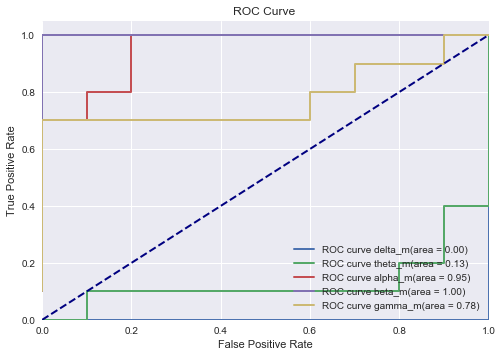

In [41]:
featuresAllROC(df, ys, range(1,6))

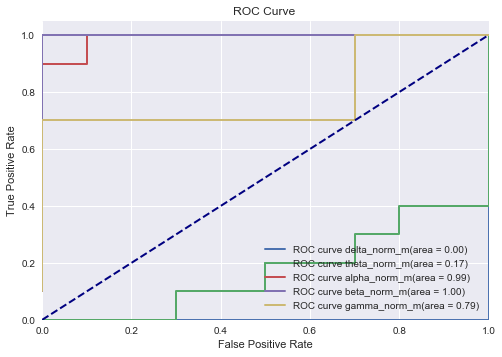

In [42]:
featuresAllROC(df, ys, range(6,11))

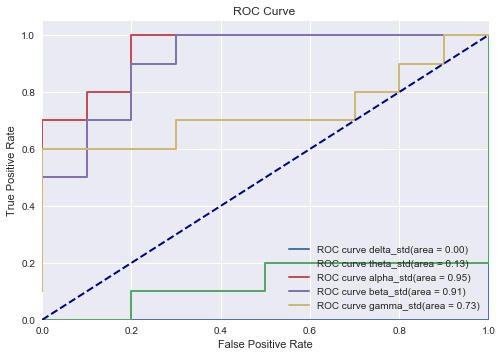

In [43]:
featuresAllROC(df, ys, range(11,16))

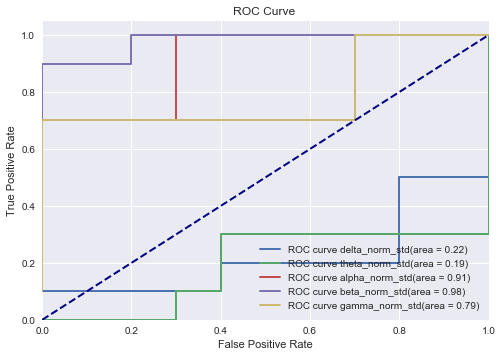

In [44]:
featuresAllROC(df, ys, range(16,21))

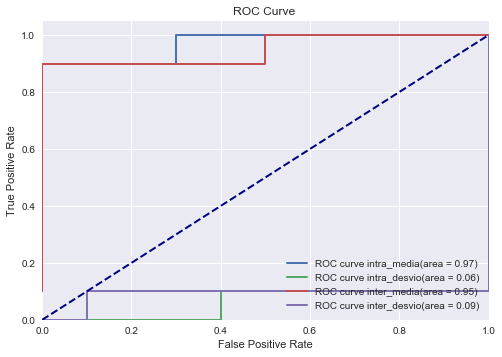

In [45]:
featuresAllROC(df, ys, range(21,25))

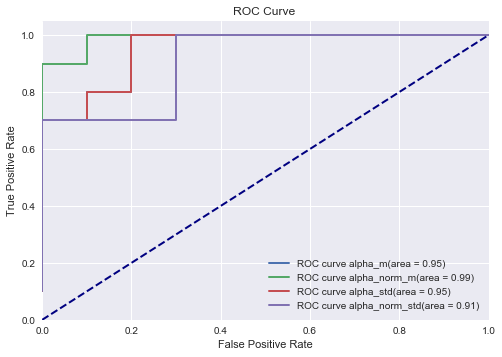

In [46]:
featuresAllROC(df, ys, [3,8,13,18])